In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import anndata
import matplotlib.pyplot as plt
sc._settings.settings._vector_friendly=True
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm

# Load IMA AD

In [2]:
ima_ad = sc.read("/lfs/local/0/yanay/uce_10000_per_dataset_33l_8ep_coarse_ct.h5ad")

In [3]:
ima_ad_human = ima_ad[ima_ad.obs.species == "human"]
ima_ad = ima_ad_human

In [4]:
ima_ad = ima_ad[ima_ad.obs["coarse_cell_type_yanay"] != "misc"]

In [5]:
ima_ad_lung = ima_ad[ima_ad.obs.tissue.str.lower().str.contains("lung")]
ima_ad_lymph = ima_ad[ima_ad.obs.tissue.str.lower().str.contains("lymph")]
ima_ad_spleen = ima_ad[(ima_ad.obs.tissue.str.lower().str.contains("spleen")) | (ima_ad.obs.tissue.str.lower().str.contains("blood"))]
ima_ad_heart = ima_ad[ima_ad.obs.tissue.str.lower().str.contains("heart")]
ima_ad_retina = ima_ad[ima_ad.obs.tissue.str.lower().str.contains("retina")]


ima_ad_lung, ima_ad_lymph, ima_ad_heart, ima_ad_retina, ima_ad_spleen

(View of AnnData object with n_obs × n_vars = 136098 × 1280
     obs: 'cell_type', 'tissue', 'idx', 'dataset', 'species', 'cell_type_gpt', 'coarse_cell_type_gpt', 'coarse_cell_type_yanay'
     uns: 'cell_type_gpt_colors', 'coarse_cell_type_yanay_colors', 'dataset_colors', 'neighbors', 'pca', 'species_colors', 'tissue_colors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 29860 × 1280
     obs: 'cell_type', 'tissue', 'idx', 'dataset', 'species', 'cell_type_gpt', 'coarse_cell_type_gpt', 'coarse_cell_type_yanay'
     uns: 'cell_type_gpt_colors', 'coarse_cell_type_yanay_colors', 'dataset_colors', 'neighbors', 'pca', 'species_colors', 'tissue_colors', 'umap'
     obsm: 'X_pca', 'X_umap'
     varm: 'PCs'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 45621 × 1280
     obs: 'cell_type', 'tissue', 'idx', 'dataset', 'species', 'cell_type_gpt', 'coarse_cell_type

# New Species Proc

In [6]:
green_monkey_ad = sc.read("/lfs/local/0/yanay/uce_temp/green_monkey_covid_uce_adata.h5ad")
nmr_spleen_ad = sc.read("/lfs/local/0/yanay/nmr_female_uce_adata.h5ad")
chicken_retina_ad = sc.read("/lfs/local/0/yanay/uce_temp/chicken_uce_adata.h5ad")
chicken_heart_ad = sc.read("/lfs/local/0/yanay/uce_temp/chicken_heart_uce_adata.h5ad")

In [7]:
green_monkey_lymph_ad = green_monkey_ad[green_monkey_ad.obs["tissue"].str.contains("Lymph")]
green_monkey_lung_ad = green_monkey_ad[green_monkey_ad.obs["tissue"].str.contains("Lung")]



green_monkey_lymph_ad_uce = sc.AnnData(green_monkey_lymph_ad.obsm["X_uce"])
green_monkey_lung_ad_uce = sc.AnnData(green_monkey_lung_ad.obsm["X_uce"])
nmr_spleen_ad_uce = sc.AnnData(nmr_spleen_ad.obsm["X_uce"])

chicken_retina_ad_uce = sc.AnnData(chicken_retina_ad.obsm["X_uce"])
chicken_heart_ad_uce = sc.AnnData(chicken_heart_ad.obsm["X_uce"])

green_monkey_lymph_ad_uce.obs = green_monkey_lymph_ad.obs
green_monkey_lung_ad_uce.obs = green_monkey_lung_ad.obs
nmr_spleen_ad_uce.obs = nmr_spleen_ad.obs
chicken_retina_ad_uce.obs = chicken_retina_ad.obs
chicken_heart_ad_uce.obs = chicken_heart_ad.obs

green_monkey_lymph_ad_uce, green_monkey_lung_ad_uce, nmr_spleen_ad_uce, chicken_retina_ad_uce, chicken_heart_ad_uce

(AnnData object with n_obs × n_vars = 30145 × 1280
     obs: 'sample', 'original_barcodes', 'tissue', 'num', 'cell_type', 'n_genes',
 AnnData object with n_obs × n_vars = 48295 × 1280
     obs: 'sample', 'original_barcodes', 'tissue', 'num', 'cell_type', 'n_genes',
 AnnData object with n_obs × n_vars = 41054 × 1280
     obs: 'sample', 'sex', 'cell_type', 'n_genes',
 AnnData object with n_obs × n_vars = 34346 × 1280
     obs: 'Cluster', 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'cell_type', 'n_genes',
 AnnData object with n_obs × n_vars = 22315 × 1280
     obs: 'sample', 'og_obs_names', 'cell_type', 'n_genes')

# Train NN Classifier on IMA Subsets

In [8]:
classifiers = {}
tissue_dict = {"lung":ima_ad_lung, "lymph":ima_ad_lymph, "heart":ima_ad_heart, "retina":ima_ad_retina, "spleen":ima_ad_spleen}
for tissue in tqdm(tissue_dict.keys()):
    X = tissue_dict[tissue].X.toarray()
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
    classifiers[tissue] = nbrs

  0%|          | 0/5 [00:00<?, ?it/s]

# Apply Classifiers to each Species

In [9]:
new_species_dict = {"lymph":green_monkey_lymph_ad_uce, "lung":green_monkey_lung_ad_uce, "spleen":nmr_spleen_ad_uce, "retina":chicken_retina_ad_uce, "heart":chicken_heart_ad_uce}
new_species_nns = {}

In [10]:
for tissue in tqdm(new_species_dict.keys()):
    if not (tissue in new_species_nns):
        print(tissue)
        nbrs = classifiers[tissue]
        ns_ad = new_species_dict[tissue]
        try:
            _, indices = nbrs.kneighbors(ns_ad.X.toarray())
        except:
            _, indices = nbrs.kneighbors(ns_ad.X)

        new_species_nns[tissue] = list(tissue_dict[tissue].obs["coarse_cell_type_yanay"].iloc[indices.flatten()].values)

  0%|          | 0/5 [00:00<?, ?it/s]

lymph
lung
spleen
retina
heart


In [11]:
new_species_nns.keys()

dict_keys(['lymph', 'lung', 'spleen', 'retina', 'heart'])

In [12]:
import pickle
with open("new_species_nns.pkl", "wb") as f:
    pickle.dump(new_species_nns, f)

In [46]:
tissue = "lung"

In [47]:
GM_ct = list(green_monkey_lung_ad_uce.obs["cell_type"].values)
GM_nn = new_species_nns[tissue]

In [48]:
[print(f'"{ct}":"",') for ct in np.unique(GM_ct)];

"B Cell":"",
"Cilated":"",
"DC":"",
"Dividing":"",
"Fibroblasts":"",
"Macrophage":"",
"Mast Cell":"",
"Monocyte":"",
"NK Cell":"",
"Neutrophil":"",
"Plasma Cell":"",
"Pneumocyte":"",
"T Cell":"",
"Vessel":"",


In [49]:
nmr_spleen_ct_map = {"B-cell":"B cell",
"CD8-T-cell":"cd8 T cell",
"Dendritic-cell":"Dendritic Cell",
"Erythroid-cell":"Erytrhoid Cell",
"Erythroid-cell.1":"Erytrhoid Cell",
"Erythroid-cell.2":"Erytrhoid Cell",
"Erythroid-cell.3":"Erytrhoid Cell",
"Ltf-high-neutrophil":"Neutrophil",
"Macrophage":"Macrophage",
"Macrophage.1":"Macrophage",
"Macrophage.2":"Macrophage",
"Mast-cell":"Mast Cell",
"Monocyte":"Monocyte",
"Multiplet":"skip",
"Naive-T-cell":"Naive T Cell",
"Neutrophil":"Neutrophil",
"Neutrophil.1":"Neutrophil",
"Neutrophil.2":"Neutrophil",
"Neutrophil.3":"Neutrophil",
"Plasma-cell":"Plasma Cell",
"Red-pulp-macrophage":"Red pulp macrophage",
"T-cell":"T cell",
"T-cell.1":"T cell",
"T-cell.2":"T cell",
"Timeless-high-dendritic-cell":"Dendritic Cell",
"Unassigned.1":"skip",
"Unassigned.2":"skip",
"Unassigned.3":"skip",
"Unassigned.4":"skip"}

In [50]:
GM_ct_mapped = np.array([nmr_spleen_ct_map.get(ct, ct) for ct in GM_ct])

skip_idx = np.where(GM_ct_mapped != "skip")
GM_ct_skipped = np.array(GM_ct_mapped)[skip_idx]
GM_nn_skipped = np.array(GM_nn)[skip_idx]


In [51]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

data = {
    '1': GM_ct_skipped,
    '2': GM_nn_skipped,
}
df = pd.DataFrame(data)
df = df.replace('NAN', np.nan)

# Get a list of labels by adding the column name to the the cell values and
# getting the discict combinations
label  = sorted(df.apply(lambda x: x).melt().dropna()['value'].unique())

# Iterate over two columns at a time to map out the relationships
output = []
for i in range(1, df.shape[1]):
    output.extend(df[[str(i),str(i+1)]].value_counts().reset_index().apply(lambda x: x).values)

# Convert the relationships to the index of the labels list
mapped = []
for x in output:
    mapped.append((label.index(x[0]), label.index(x[1]), x[2]))

# Split the values into their corresponding buckets
source, target, value = np.array(mapped).T

# Build your chart
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
        label = label,
            color = "blue"
        
    ),
    link = dict(
      source = source,
        target = target,
        value = value
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

In [20]:
df

,1,2
0,Ltf-high-neutrophil,monocyte
1,T-cell,cd8 t cell
2,Ltf-high-neutrophil,monocyte
3,B-cell,b cell
4,T-cell,cd4 t cell
...,...,...
41049,Neutrophil.1,granulocyte
41050,Neutrophil.2,hematopoietic cell
41051,Erythroid-cell.2,hematopoietic cell
41052,Neutrophil.1,hematopoietic cell


# Try Dendrograms

In [56]:
import anndata

In [78]:
green_monkey_lung_ad_uce = green_monkey_lung_ad_uce.copy()
nmr_spleen_ad_uce = nmr_spleen_ad_uce.copy()
green_monkey_lymph_ad_uce = green_monkey_lymph_ad_uce.copy()

In [79]:
green_monkey_lung_ad_uce.obs["coarse_cell_type_yanay"] = green_monkey_lung_ad_uce.obs["cell_type"]
green_monkey_lymph_ad_uce.obs["coarse_cell_type_yanay"] = green_monkey_lymph_ad_uce.obs["cell_type"]
nmr_spleen_ad_uce.obs["coarse_cell_type_yanay"] = nmr_spleen_ad_uce.obs["cell_type"]

In [84]:
lung_joint = anndata.concat({"green monkey":green_monkey_lymph_ad_uce, "human":ima_ad_lymph}, label="species")
lung_joint

AnnData object with n_obs × n_vars = 60005 × 1280
    obs: 'tissue', 'cell_type', 'coarse_cell_type_yanay', 'species'

In [85]:
species_and_cell_type = lung_joint.obs["species"].str.cat(lung_joint.obs["coarse_cell_type_yanay"], sep=": ")
lung_joint.obs["species_and_cell_type"] = pd.Categorical(species_and_cell_type)

In [86]:
sc.tl.dendrogram(lung_joint, groupby="species_and_cell_type", use_rep="X")

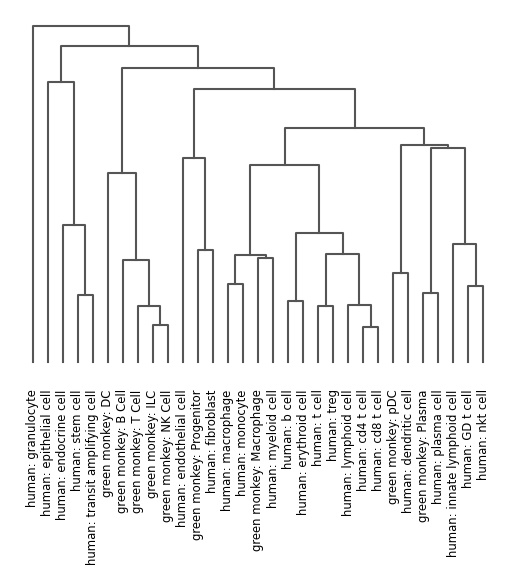

<Axes: >

In [87]:
sc.pl.dendrogram(lung_joint, groupby="species_and_cell_type")

# Try Log Reg

# Train NN Classifier on IMA Subsets

In [89]:
from sklearn.linear_model import LogisticRegression

In [90]:
lr_classifiers = {}
tissue_dict = {"lung":ima_ad_lung, "lymph":ima_ad_lymph, "heart":ima_ad_heart, "retina":ima_ad_retina, "spleen":ima_ad_spleen}
for tissue in tqdm(tissue_dict.keys()):
    X = tissue_dict[tissue].X.toarray()
    y = tissue_dict[tissue].obs["coarse_cell_type_yanay"].values
    clf = LogisticRegression(random_state=0).fit(X, y)
    lr_classifiers[tissue] = clf

  0%|          | 0/5 [00:00<?, ?it/s]

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/lfs/hyperturing2/0/yanay/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/lfs/hyperturing2/0/

In [95]:
new_species_dict = {"lymph":green_monkey_lymph_ad_uce, "lung":green_monkey_lung_ad_uce, "spleen":nmr_spleen_ad_uce, "retina":chicken_retina_ad_uce, "heart":chicken_heart_ad_uce}
new_species_lr_preds = {}

In [99]:
for tissue in tqdm(new_species_dict.keys()):
    if not (tissue in new_species_lr_preds):
        print(tissue)
        lr_clf = lr_classifiers[tissue]
        ns_ad = new_species_dict[tissue]
        try:
            preds = lr_clf.predict(ns_ad.X.toarray())
        except:
            preds = lr_clf.predict(ns_ad.X)

        new_species_lr_preds[tissue] = preds

  0%|          | 0/5 [00:00<?, ?it/s]

lymph
lung
spleen
retina
heart


In [271]:
lymph_correct_df = pd.DataFrame()
lymph_correct_df["green_monkey_cell_type"] = green_monkey_lymph_ad_uce.obs["cell_type"]
lymph_correct_df["predicted_cell_type"] = new_species_lr_preds["lymph"]
pd.DataFrame(lymph_correct_df.groupby(["green_monkey_cell_type", "predicted_cell_type"]).agg(len)).to_csv("lymph_agg.csv", index=True)

In [272]:
lung_correct_df = pd.DataFrame()
lung_correct_df["green_monkey_cell_type"] = green_monkey_lung_ad_uce.obs["cell_type"]
lung_correct_df["predicted_cell_type"] = new_species_lr_preds["lung"]
pd.DataFrame(lung_correct_df.groupby(["green_monkey_cell_type", "predicted_cell_type"]).agg(len)).to_csv("lung_agg.csv", index=True)

In [273]:
spleen_correct_df = pd.DataFrame()
spleen_correct_df["naked_mole_rat_cell_type"] = nmr_spleen_ad_uce.obs["cell_type"]
spleen_correct_df["predicted_cell_type"] = new_species_lr_preds["spleen"]
pd.DataFrame(spleen_correct_df.groupby(["naked_mole_rat_cell_type", "predicted_cell_type"]).agg(len)).to_csv("spleen_agg.csv", index=True)

In [274]:
retina_correct_df = pd.DataFrame()
retina_correct_df["chicken_cell_type"] = chicken_retina_ad_uce.obs["cell_type"]
retina_correct_df["predicted_cell_type"] = new_species_lr_preds["retina"]
pd.DataFrame(retina_correct_df.groupby(["chicken_cell_type", "predicted_cell_type"]).agg(len)).to_csv("retina_agg.csv", index=True)

In [275]:
heart_correct_df = pd.DataFrame()
heart_correct_df["chicken_cell_type"] = chicken_heart_ad_uce.obs["cell_type"]
heart_correct_df["predicted_cell_type"] = new_species_lr_preds["heart"]
pd.DataFrame(heart_correct_df.groupby(["chicken_cell_type", "predicted_cell_type"]).agg(len)).to_csv("heart_agg.csv", index=True)

# Confusion Matrix

In [5]:
base_dir = '/dfs/project/cross-species/yanay/code/Benchmark UCE/'


In [47]:
lymph_correct_df = pd.read_csv(base_dir + 'lymph_correct_df.csv')
lung_correct_df = pd.read_csv(base_dir + 'lung_agg.csv')
spleen_correct_df = pd.read_csv(base_dir + 'spleen_agg.csv')
retina_correct_df = pd.read_csv(base_dir + 'retina_agg.csv')
heart_correct_df = pd.read_csv(base_dir + 'heart_agg.csv')
spleen_correct_df = pd.read_csv(base_dir + 'spleen_correct_df.csv')


In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [45]:
nmr_spleen_ct_map = {"B-cell":"B cell",
"CD8-T-cell":"cd8 T cell",
"Dendritic-cell":"Dendritic Cell",
"Erythroid-cell":"Erytrhoid Cell",
"Erythroid-cell.1":"Erytrhoid Cell",
"Erythroid-cell.2":"Erytrhoid Cell",
"Erythroid-cell.3":"Erytrhoid Cell",
"Ltf-high-neutrophil":"Neutrophil",
"Macrophage":"Macrophage",
"Macrophage.1":"Macrophage",
"Macrophage.2":"Macrophage",
"Mast-cell":"Mast Cell",
"Monocyte":"Monocyte",
"Multiplet":"skip",
"Naive-T-cell":"Naive T Cell",
"Neutrophil":"Neutrophil",
"Neutrophil.1":"Neutrophil",
"Neutrophil.2":"Neutrophil",
"Neutrophil.3":"Neutrophil",
"Plasma-cell":"Plasma Cell",
"Red-pulp-macrophage":"Red pulp macrophage",
"T-cell":"T cell",
"T-cell.1":"T cell",
"T-cell.2":"T cell",
"Timeless-high-dendritic-cell":"Dendritic Cell",
"Unassigned.1":"skip",
"Unassigned.2":"skip",
"Unassigned.3":"skip",
"Unassigned.4":"skip"}

lymph_ct_map = {'T Cell':'t cell',
'B Cell':'b cell',
'Plasma':'plasma cell',
'DC':'dendritic cell',
'pDC':'plasmacytoid dendritic cell',
'Progenitor':'progenitor cell',
'NK Cell':'nk cell',
'Macrophage':'macrophage',
'ILC':'innate lymphoid cell'}

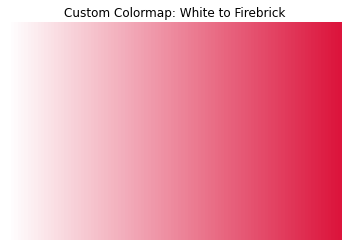

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define the colors for the updated colormap - from White to Firebrick
colors_updated = [(1, 1, 1), (178/255, 34/255, 34/255)]  # White to Crimson
n_bins = 100  # Number of bins in the colormap

# Create a LinearSegmentedColormap
colormap = LinearSegmentedColormap.from_list("CustomColormap", colors, N=n_bins)

# Create a test image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the colormap
plt.imshow(gradient, aspect='auto', cmap=colormap)
plt.title("Custom Colormap: White to Firebrick")
plt.axis('off')
plt.show()

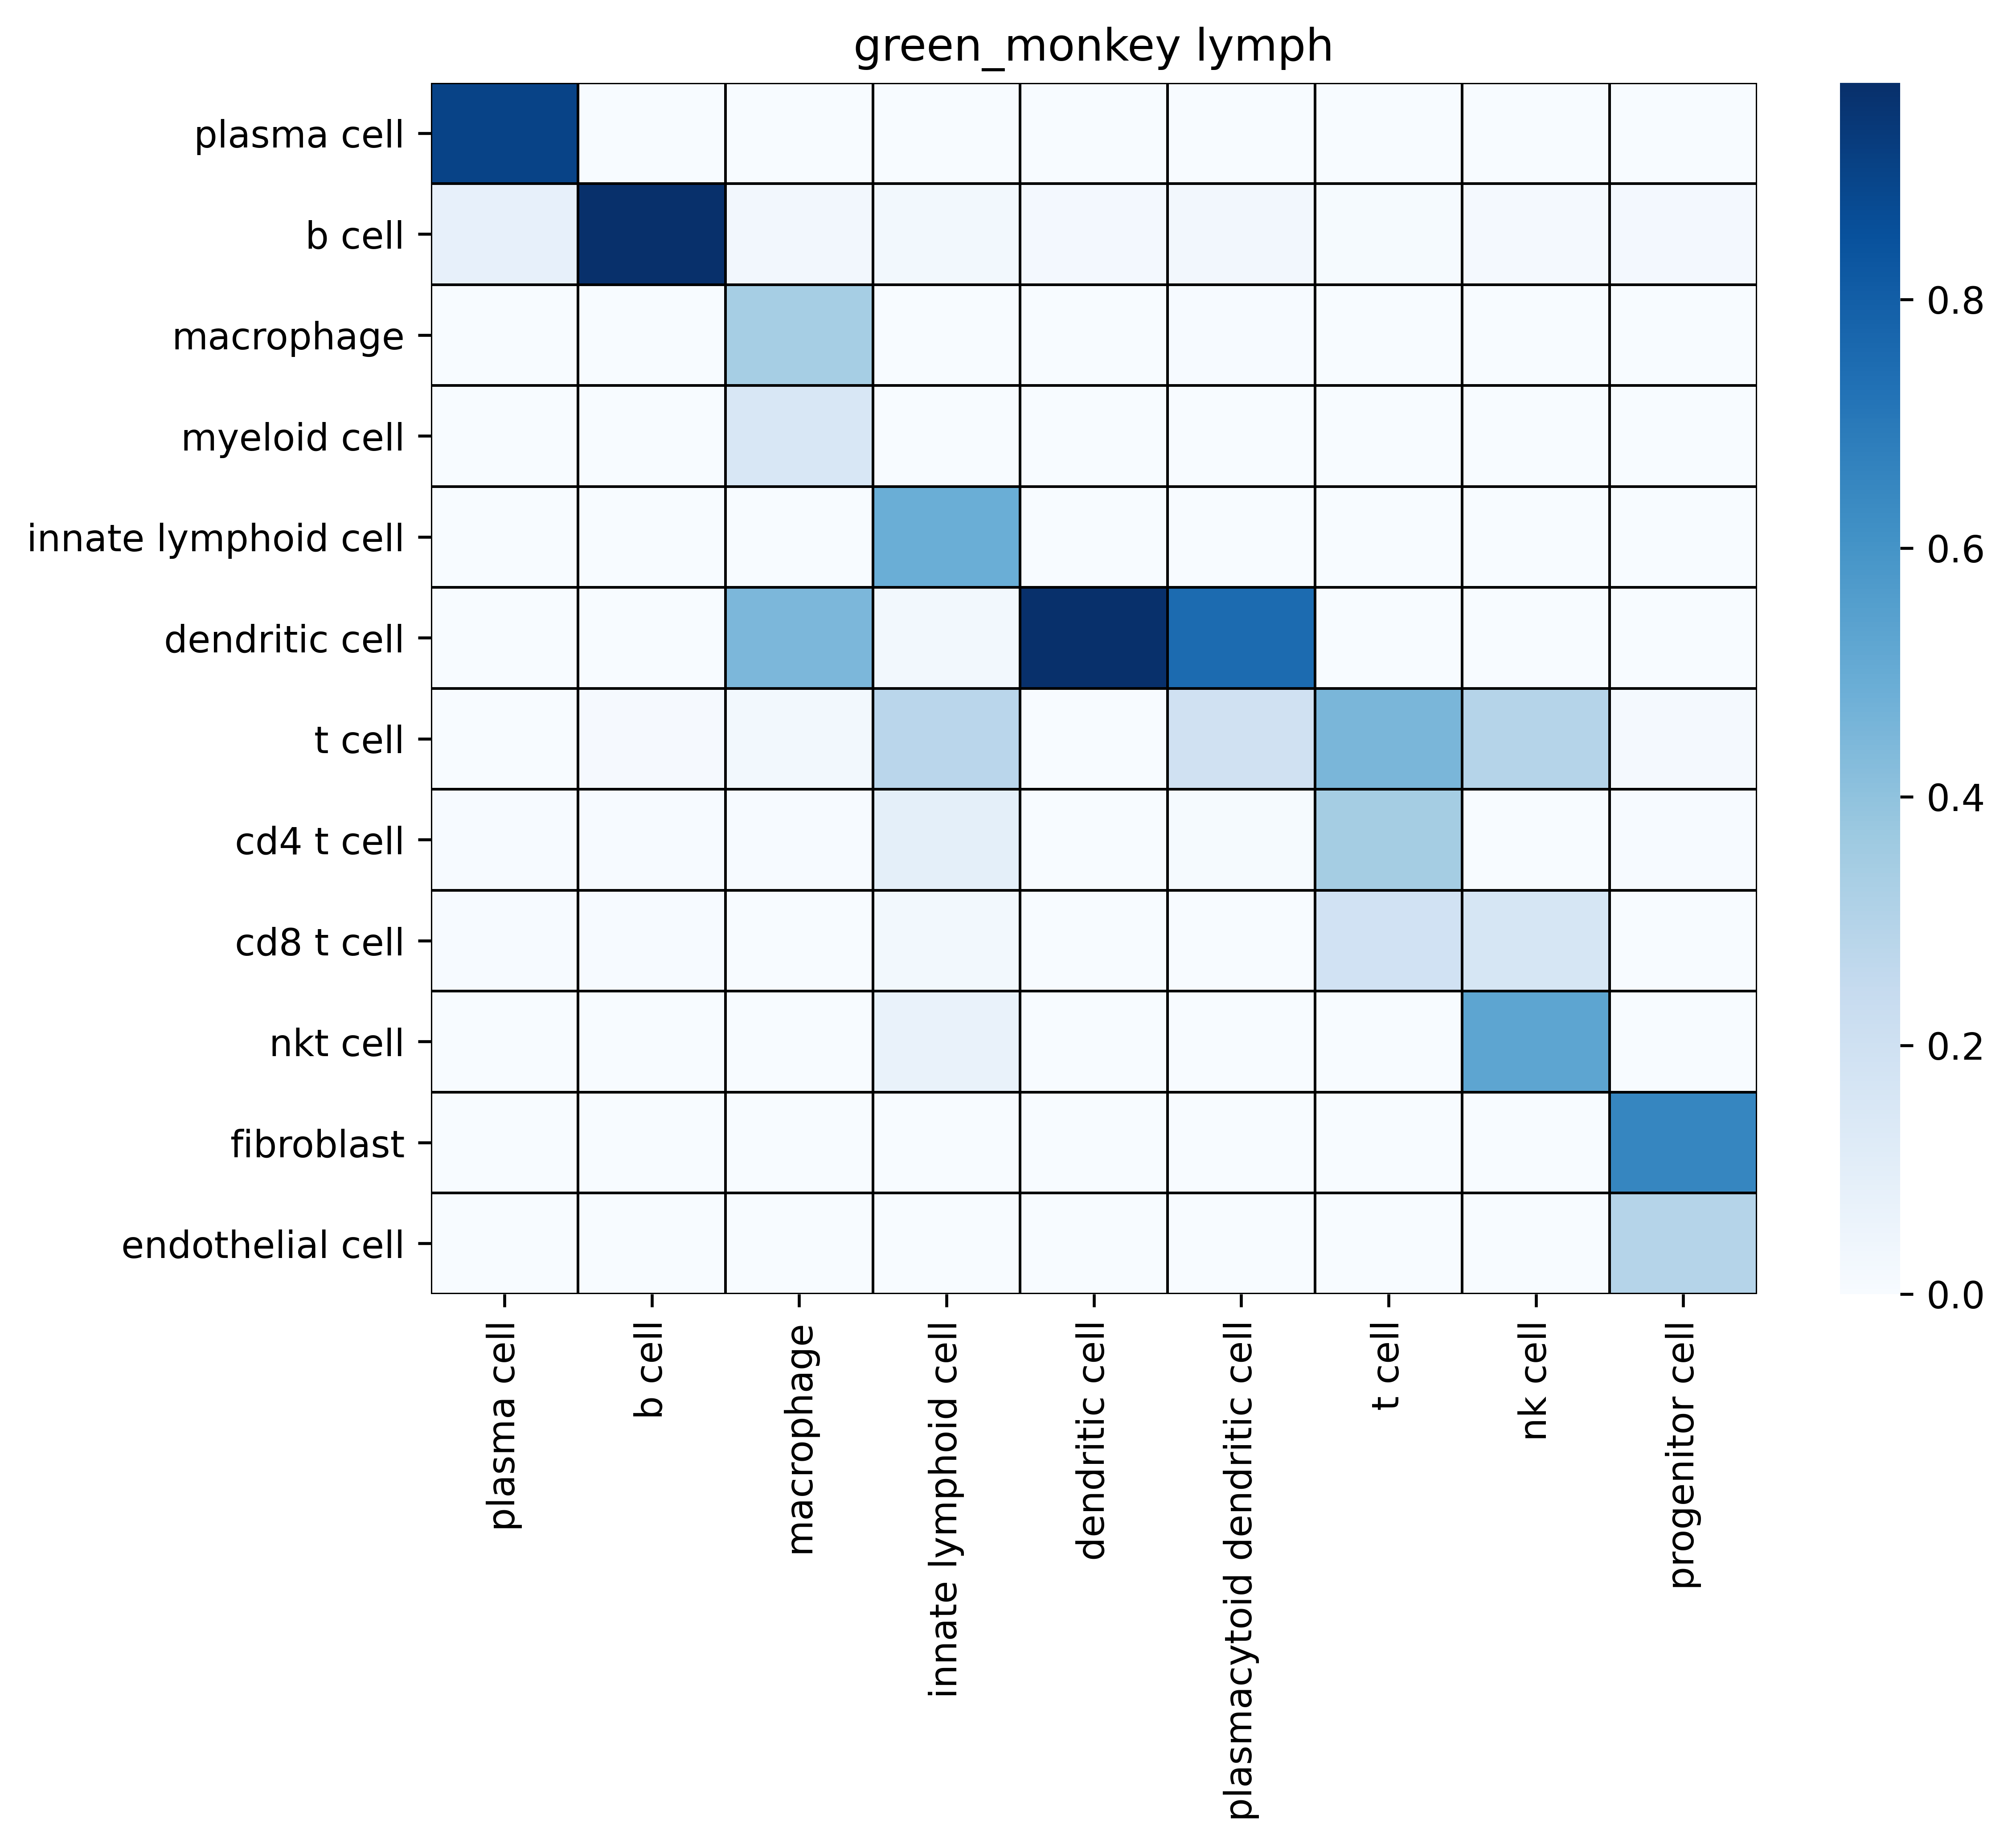

In [98]:
# just create the cfm 

def create_heatmap(species_correct_ad, cell_type_map, species, tissue, ax, xorder=None, yorder=None):
    
    species_correct_ad["mapped_ct"] = [cell_type_map.get(ct, ct).lower() for ct in species_correct_ad[f"{species}_cell_type"]]
    species_correct_ad_skip = species_correct_ad[species_correct_ad["mapped_ct"] != "skip"]

    species_correct_ad_skip["mapped_ct_num"] = pd.Categorical(species_correct_ad_skip["mapped_ct"]).codes
    species_correct_ad_skip["predicted_cell_type_num"] = pd.Categorical(species_correct_ad_skip["predicted_cell_type"]).codes


    pred_labels = pd.Categorical(species_correct_ad_skip["predicted_cell_type"].unique()).categories
    true_labels = pd.Categorical(species_correct_ad_skip["mapped_ct"].unique()).categories

    cfm = np.zeros((len(pred_labels), len(true_labels)))
    
    

    for row in species_correct_ad_skip.iterrows():
        cfm[row[1]["predicted_cell_type_num"], row[1]["mapped_ct_num"]] += 1
    
    if xorder is not None:
        assert(len(np.unique(xorder)) == len(true_labels))
        assert(len(np.unique(yorder)) == len(pred_labels))
        
        cfm = cfm[yorder, :][:, xorder]
        pred_labels = pred_labels[yorder]
        true_labels = true_labels[xorder]
    # row noramlize
    cfm_rn = cfm / cfm.sum(0)[np.newaxis, :np.newaxis]
    
    idx = np.where(cfm_rn.max(1)>0.01)[0]
    cfm_rn = cfm_rn[idx, :]
    
    #to_keep = np.where([cfm_rn.max(1)>0.01])[0]
    #cfm_rn = cfm_rn[to_keep, :]
    pred_labels = np.array(pred_labels)[idx]
    
    sns.heatmap(cfm_rn, xticklabels=true_labels, 
                yticklabels=pred_labels, ax=ax,
                cmap='Blues', linewidths=0.5, linecolor='black')
    plt.title(f"{species} {tissue}")
    #plt.savefig(base_dir + "figures/fig2_{species}_heatmap.svg")
    
    return cfm_rn
    

fig, ax = plt.subplots(1,1, figsize=(8, 6), dpi=600)
xorder = [5,0,3,2,1,6,8,4, 7]
yorder = [11, 0,8, 9,7,3,12,1,2,10,13,6,4,5]
cfm_rn = create_heatmap(lymph_correct_df, lymph_ct_map, "green_monkey", "lymph", ax, xorder, yorder)


In [11]:
cell_type_map = nmr_spleen_ct_map
species_correct_ad = spleen_correct_df 
species = 'naked_mole_rat'
tissue = 'spleen'

In [27]:
species_correct_ad_skip

,naked_mole_rat_cell_type,predicted_cell_type,mapped_ct,mapped_ct_num,predicted_cell_type_num
0,Ltf-high-neutrophil,granulocyte,neutrophil,8,8
1,T-cell,cd4 t cell,t cell,11,2
2,Ltf-high-neutrophil,monocyte,neutrophil,8,11
3,B-cell,b cell,b cell,0,1
4,T-cell,cd4 t cell,t cell,11,2
...,...,...,...,...,...
41049,Neutrophil.1,granulocyte,neutrophil,8,8
41050,Neutrophil.2,erythroid cell,neutrophil,8,7
41051,Erythroid-cell.2,erythroid cell,erytrhoid cell,3,7
41052,Neutrophil.1,monocyte,neutrophil,8,11


In [13]:
species_correct_ad["mapped_ct"] = [cell_type_map.get(ct, ct).lower() for ct in species_correct_ad[f"{species}_cell_type"]]
species_correct_ad_skip = species_correct_ad[species_correct_ad["mapped_ct"] != "skip"]

species_correct_ad_skip["mapped_ct_num"] = pd.Categorical(species_correct_ad_skip["mapped_ct"]).codes
species_correct_ad_skip["predicted_cell_type_num"] = pd.Categorical(species_correct_ad_skip["predicted_cell_type"]).codes

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [24]:
pred_labels = pd.Categorical(species_correct_ad_skip["predicted_cell_type"].unique()).categories
pred_labels = [x for x in pred_labels if x in true_labels] + [x for x in pred_labels if x not in true_labels]
true_labels = pd.Categorical(species_correct_ad_skip["mapped_ct"].unique()).categories

cfm = np.zeros((len(pred_labels), len(true_labels)))

Text(0.5, 1.0, 'naked_mole_rat spleen')

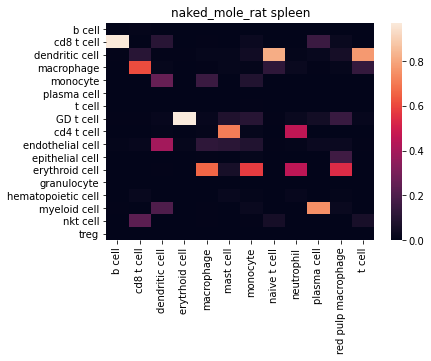

In [25]:
for row in species_correct_ad_skip.iterrows():
    cfm[row[1]["predicted_cell_type_num"], row[1]["mapped_ct_num"]] += 1

# row noramlize
cfm_rn = cfm / cfm.sum(0)[np.newaxis, :np.newaxis]
sns.heatmap(cfm_rn, xticklabels=true_labels, yticklabels=pred_labels)
plt.title(f"{species} {tissue}")

In [302]:
# just create the cfm 

def create_heatmap(species_correct_ad, cell_type_map, species, tissue):
    
    species_correct_ad["mapped_ct"] = [cell_type_map.get(ct, ct).lower() for ct in species_correct_ad[f"{species}_cell_type"]]
    species_correct_ad_skip = species_correct_ad[species_correct_ad["mapped_ct"] != "skip"]

    species_correct_ad_skip["mapped_ct_num"] = pd.Categorical(species_correct_ad_skip["mapped_ct"]).codes
    species_correct_ad_skip["predicted_cell_type_num"] = pd.Categorical(species_correct_ad_skip["predicted_cell_type"]).codes


    pred_labels = pd.Categorical(species_correct_ad_skip["predicted_cell_type"].unique()).categories
    true_labels = pd.Categorical(species_correct_ad_skip["mapped_ct"].unique()).categories

    cfm = np.zeros((len(pred_labels), len(true_labels)))

    for row in species_correct_ad_skip.iterrows():
        cfm[row[1]["predicted_cell_type_num"], row[1]["mapped_ct_num"]] += 1

    # row noramlize
    cfm_rn = cfm / cfm.sum(0)[np.newaxis, :np.newaxis]
    sns.heatmap(cfm_rn, xticklabels=true_labels, yticklabels=pred_labels)
    plt.title(f"{species} {tissue}")

In [303]:
import warnings
warnings.filterwarnings("ignore")

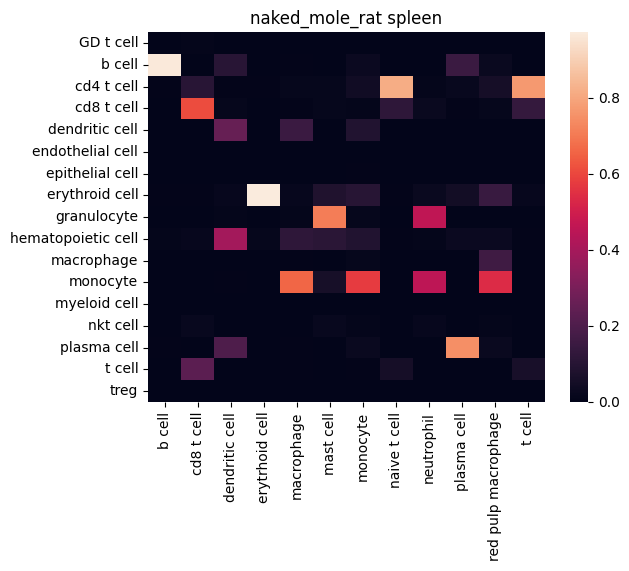

In [304]:
create_heatmap(spleen_correct_df, nmr_spleen_ct_map, "naked_mole_rat", "spleen")

In [298]:
spleen_correct_df.to_csv("spleen_correct_df.csv", index=False)

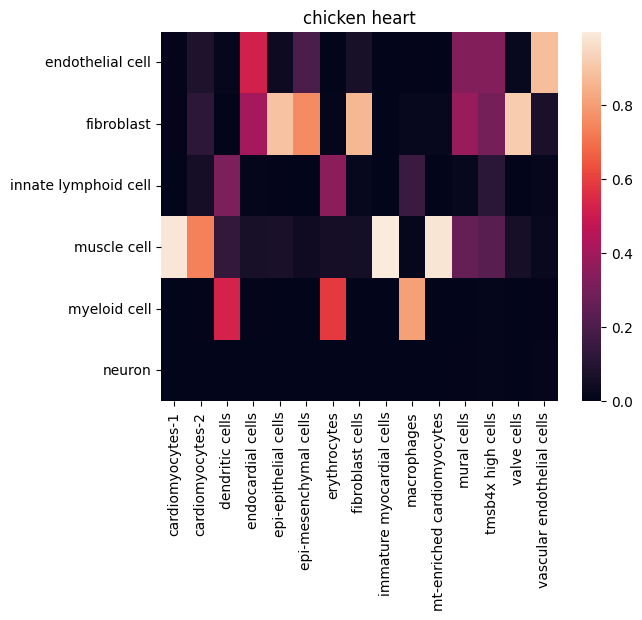

In [292]:
create_heatmap(heart_correct_df, nmr_spleen_ct_map, "chicken", "heart")

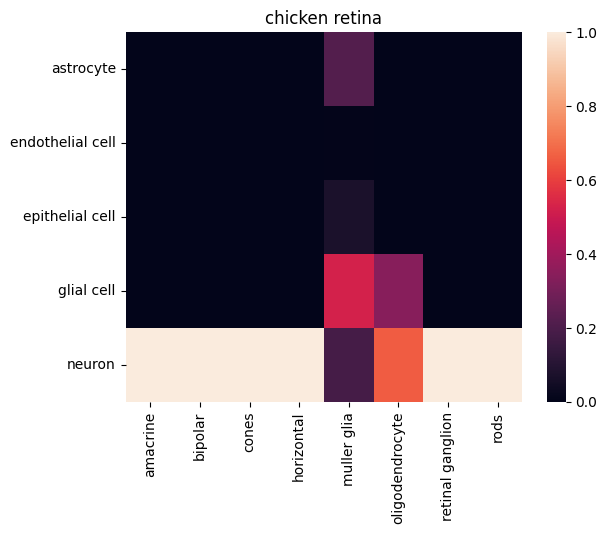

In [295]:
create_heatmap(retina_correct_df, nmr_spleen_ct_map, "chicken", "retina")

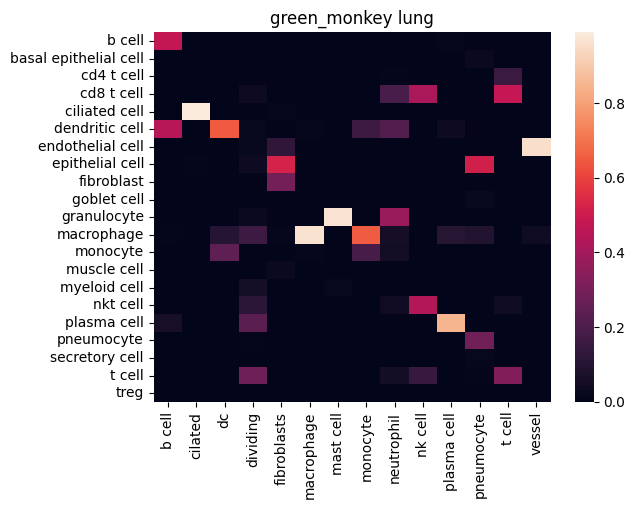

In [293]:
create_heatmap(lung_correct_ad, nmr_spleen_ct_map, "green_monkey", "lung")

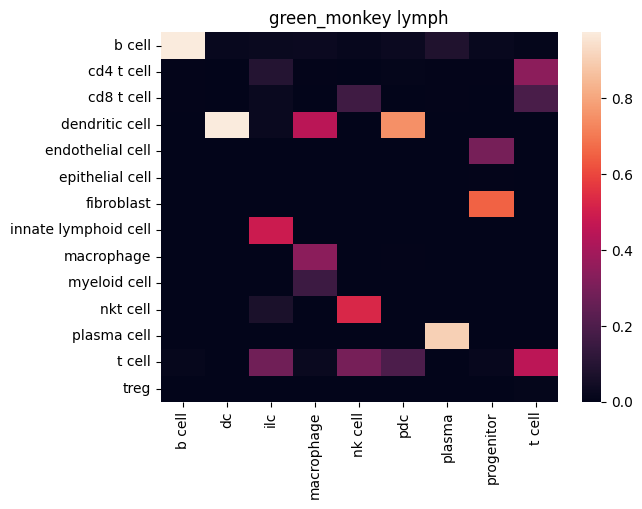

In [294]:
create_heatmap(lymph_correct_df, nmr_spleen_ct_map, "green_monkey", "lymph")